In [19]:
import numpy as np, sys,os
import pandas as pd
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
sys.path.insert(0, "..")
import src.utils.dtw as dtw
import numpy as np
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils import check_random_state

In [20]:
# Cargar los datos desde el archivo JSON
timeSeries = pd.read_json('../data/processed/realData.json', orient='records', lines=True)

# Filtrar las series de tiempo por clase
healthy_cop_x = timeSeries[timeSeries['class'] == 'Healthy']['cop_x']
neuropathic_cop_x = timeSeries[timeSeries['class'] == 'Neuropathic']['cop_x']
diabetic_cop_x = timeSeries[timeSeries['class'] == 'Diabetic']['cop_x']

healthy_cop_y = timeSeries[timeSeries['class'] == 'Healthy']['cop_y']
neuropathic_cop_y = timeSeries[timeSeries['class'] == 'Neuropathic']['cop_y']
diabetic_cop_y = timeSeries[timeSeries['class'] == 'Diabetic']['cop_y']

# Convertir las listas de coordenadas en arrays numpy
healthy_cop_x = np.array([np.array(series) for series in healthy_cop_x])
neuropathic_cop_x = np.array([np.array(series) for series in neuropathic_cop_x])
diabetic_cop_x = np.array([np.array(series) for series in diabetic_cop_x])

healthy_cop_y = np.array([np.array(series) for series in healthy_cop_y])
neuropathic_cop_y = np.array([np.array(series) for series in neuropathic_cop_y])
diabetic_cop_y = np.array([np.array(series) for series in diabetic_cop_y])

# Asegurarse de que las etiquetas sean numéricas
label_map = {'Healthy': 0, 'Diabetic': 1, 'Neuropathic': 2}
y = timeSeries['class'].map(label_map).values

# Asegurarse de que las series de tiempo tengan la forma (n_samples, n_timestamps, n_features)
if healthy_cop_x.ndim == 2:
    healthy_cop_x = np.expand_dims(healthy_cop_x, axis=2)
if neuropathic_cop_x.ndim == 2:
    neuropathic_cop_x = np.expand_dims(neuropathic_cop_x, axis=2)
if diabetic_cop_x.ndim == 2:
    diabetic_cop_x = np.expand_dims(diabetic_cop_x, axis=2)

if healthy_cop_y.ndim == 2:
    healthy_cop_y = np.expand_dims(healthy_cop_y, axis=2)
if neuropathic_cop_y.ndim == 2:
    neuropathic_cop_y = np.expand_dims(neuropathic_cop_y, axis=2)
if diabetic_cop_y.ndim == 2:
    diabetic_cop_y = np.expand_dims(diabetic_cop_y, axis=2)

In [21]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils import check_random_state

In [22]:

def random_guided_warp(x, labels, num_samples, slope_constraint="symmetric", use_window=True, dtw_type="normal", verbose=0):
    # use verbose = -1 to turn off warnings
    # slope_constraint is for DTW. "symmetric" or "asymmetric"
    # dtw_type is for shapeDTW or DTW. "normal" or "shape"
    #TODO: Reconocer referencia de github y referencia del paper
    if use_window:
        window = np.ceil(x.shape[1] / 10.).astype(int)
    else:
        window = None
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
    ret = np.zeros((num_samples, x.shape[1], x.shape[2]))
    for i in tqdm(range(num_samples)):
        # Randomly select an index from the dataset
        index = np.random.randint(0, x.shape[0])
        pat = x[index]
        # Guarantees that the same one isn't selected
        choices = np.delete(np.arange(x.shape[0]), index)
        # Remove ones of different classes
        choices = choices[l[choices] == l[index]]
        if choices.size > 0:        
            # Pick random intra-class pattern
            random_prototype = x[np.random.choice(choices)]
            
            if dtw_type == "shape":
                path = dtw.shape_dtw(random_prototype, pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
            else:
                path = dtw.dtw(random_prototype, pat, dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
                            
            # Time warp
            warped = pat[path[1]]
            for dim in range(x.shape[2]):
                ret[i,:,dim] = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=warped.shape[0]), warped[:,dim]).T
        else:
            if verbose > -1:
                print("There is only one pattern of class %d, skipping timewarping"%l[index])
            ret[i,:] = pat
    return ret



In [23]:
# Asumiendo que quieres generar 100 datos aumentados por clase
num_samples = 1600

# Llamar a la función spawner para cada clase
rgw_healthy_x = random_guided_warp(healthy_cop_x, y[timeSeries['class'] == 'Healthy'], num_samples)
rgw_neuropathic_x = random_guided_warp(neuropathic_cop_x, y[timeSeries['class'] == 'Neuropathic'], num_samples)
rgw_diabetic_x = random_guided_warp(diabetic_cop_x, y[timeSeries['class'] == 'Diabetic'], num_samples)

rgw_healthy_y = random_guided_warp(healthy_cop_y, y[timeSeries['class'] == 'Healthy'], num_samples)
rgw_neuropathic_y = random_guided_warp(neuropathic_cop_y, y[timeSeries['class'] == 'Neuropathic'], num_samples)
rgw_diabetic_y = random_guided_warp(diabetic_cop_y, y[timeSeries['class'] == 'Diabetic'], num_samples)

100%|██████████| 1600/1600 [01:19<00:00, 20.09it/s]


In [24]:
import pandas as pd
import numpy as np

def convertir_a_serie_de_tiempo(data):
    series_de_tiempo = []
    for i in range(data.shape[0]):
        serie = data[i, :, 0]  # Tomamos solo la primera característica por paso de tiempo
        series_de_tiempo.append(serie)
    return np.array(series_de_tiempo)  # Convertimos la lista de arrays en un array de NumPy

series_de_tiempo_x_healthy = convertir_a_serie_de_tiempo(rgw_healthy_x)
series_de_tiempo_x_neuropathic = convertir_a_serie_de_tiempo(rgw_neuropathic_x)
series_de_tiempo_x_diabetic = convertir_a_serie_de_tiempo(rgw_diabetic_x)
series_de_tiempo_y_healthy = convertir_a_serie_de_tiempo(rgw_healthy_y)
series_de_tiempo_y_neuropathic = convertir_a_serie_de_tiempo(rgw_neuropathic_y)
series_de_tiempo_y_diabetic = convertir_a_serie_de_tiempo(rgw_diabetic_y)

cop_x_data = np.concatenate((series_de_tiempo_x_healthy, series_de_tiempo_x_neuropathic, series_de_tiempo_x_diabetic))
cop_y_data = np.concatenate((series_de_tiempo_y_healthy, series_de_tiempo_y_neuropathic, series_de_tiempo_y_diabetic))
len(cop_y_data.tolist())
len(cop_x_data.tolist())

4800

In [25]:

rgw_data = pd.DataFrame({
    'cop_x': cop_x_data.tolist(),  
    'cop_y': cop_y_data.tolist(), 
    'class': ['Healthy'] * 1600 + ['Neuropathic'] * 1600 + ['Diabetic'] * 1600,
    'flag': 'augmented'
})


rgw_data

,cop_x,cop_y,class,flag
0,"[-0.002071877, -0.002071877, -0.002071877, -0....","[0.45742360190000003, 0.3013314947410822, 0.18...",Healthy,augmented
1,"[-0.0811466529, -0.0811466529, -0.0811466529, ...","[0.6589650982, 0.6589650982, 0.6589650982, 0.6...",Healthy,augmented
2,"[0.0809286872, 0.06457593119098197, 0.05103516...","[0.0383615032, 0.0462189572, 0.0462189572, 0.0...",Healthy,augmented
3,"[-0.06350466340000001, -0.06201455863406814, -...","[-0.8374626650000001, -0.7516868657727456, -0....",Healthy,augmented
4,"[0.6464988651, 0.6535081193897796, 0.632901580...","[0.9729360741, 0.8549511328613227, 0.783906403...",Healthy,augmented
...,...,...,...,...
4795,"[0.9657484043000001, 0.8851376263771543, 0.791...","[1.9805386425, 1.7612507443326655, 1.515740642...",Diabetic,augmented
4796,"[-0.4129606511, -0.4460454157436874, -0.450110...","[-0.2077563557, -0.2031553872987976, -0.182937...",Diabetic,augmented
4797,"[0.5290670792000001, 0.5290670792000001, 0.529...","[-1.2784833302, -1.4660341077633268, -1.609364...",Diabetic,augmented
4798,"[0.2878039548, 0.37896810577715434, 0.44939688...","[0.075402021, 0.1698625420723447, 0.2317537998...",Diabetic,augmented


In [26]:
rgw_data.to_json('../data/processed/rgw_data.json', orient='records', lines=True)

In [27]:
conteo_clase = rgw_data['class'].value_counts()

print("Conteo de valores en la columna 'class':")
print(conteo_clase)


Conteo de valores en la columna 'class':
class
Healthy        1600
Neuropathic    1600
Diabetic       1600
Name: count, dtype: int64


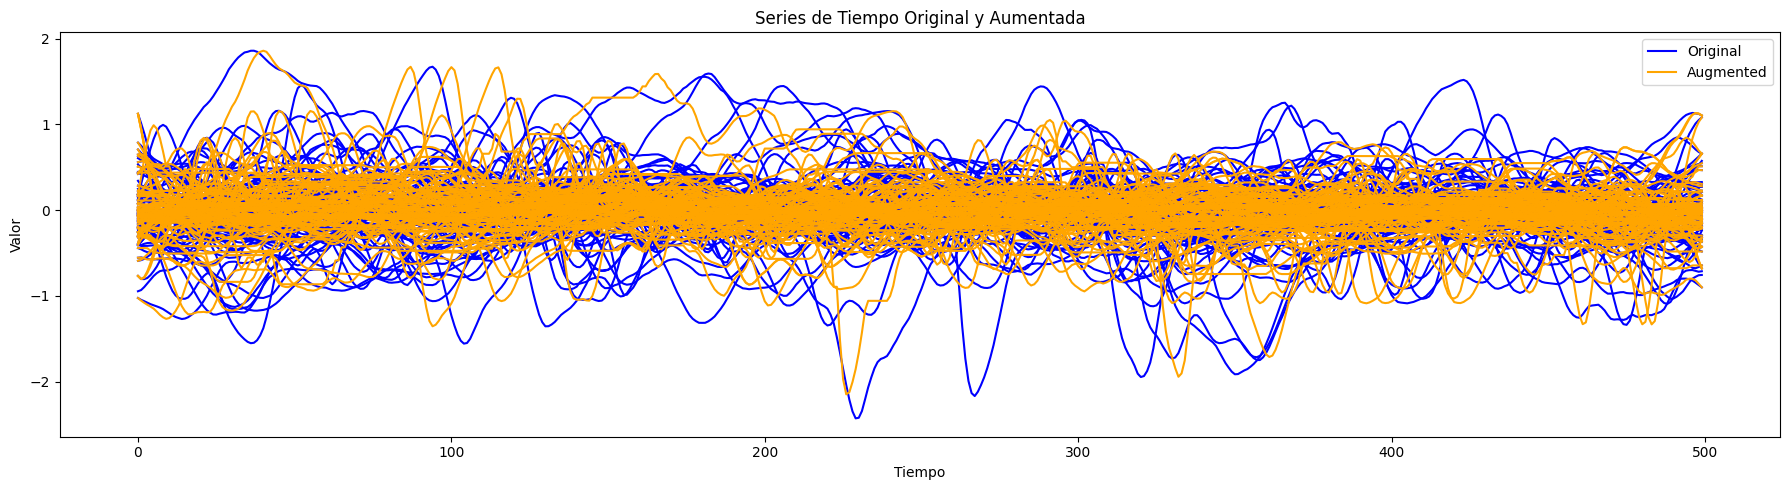

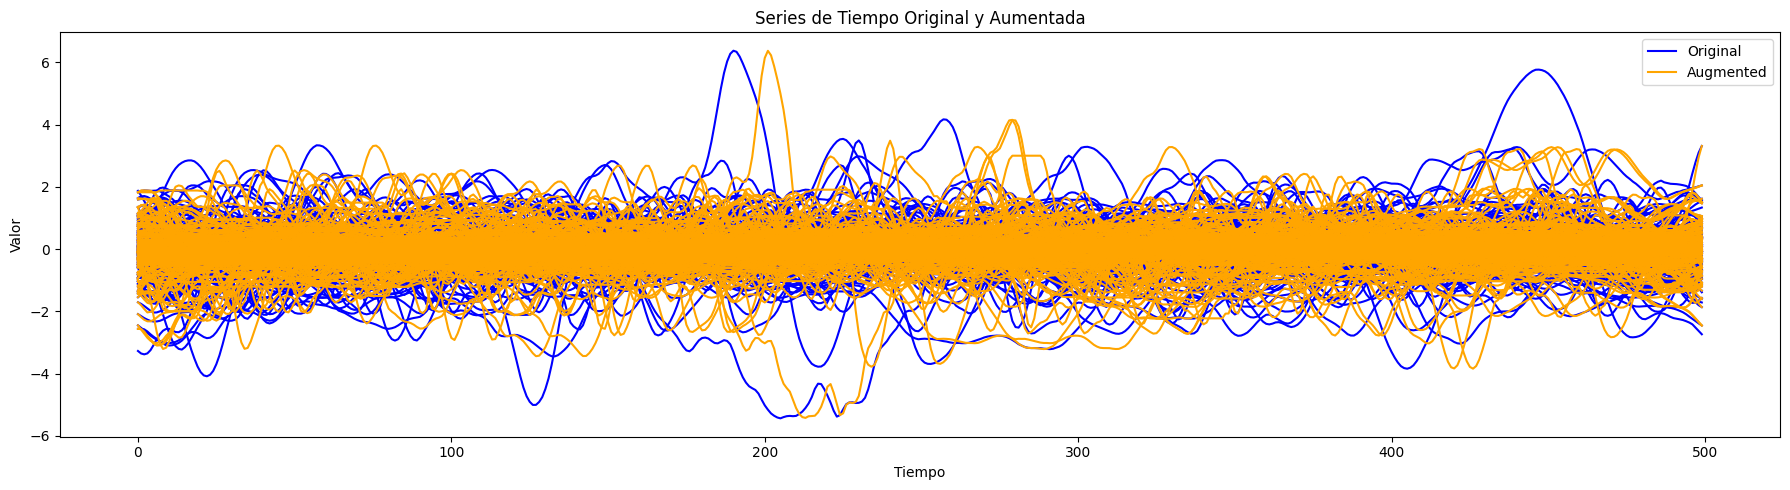

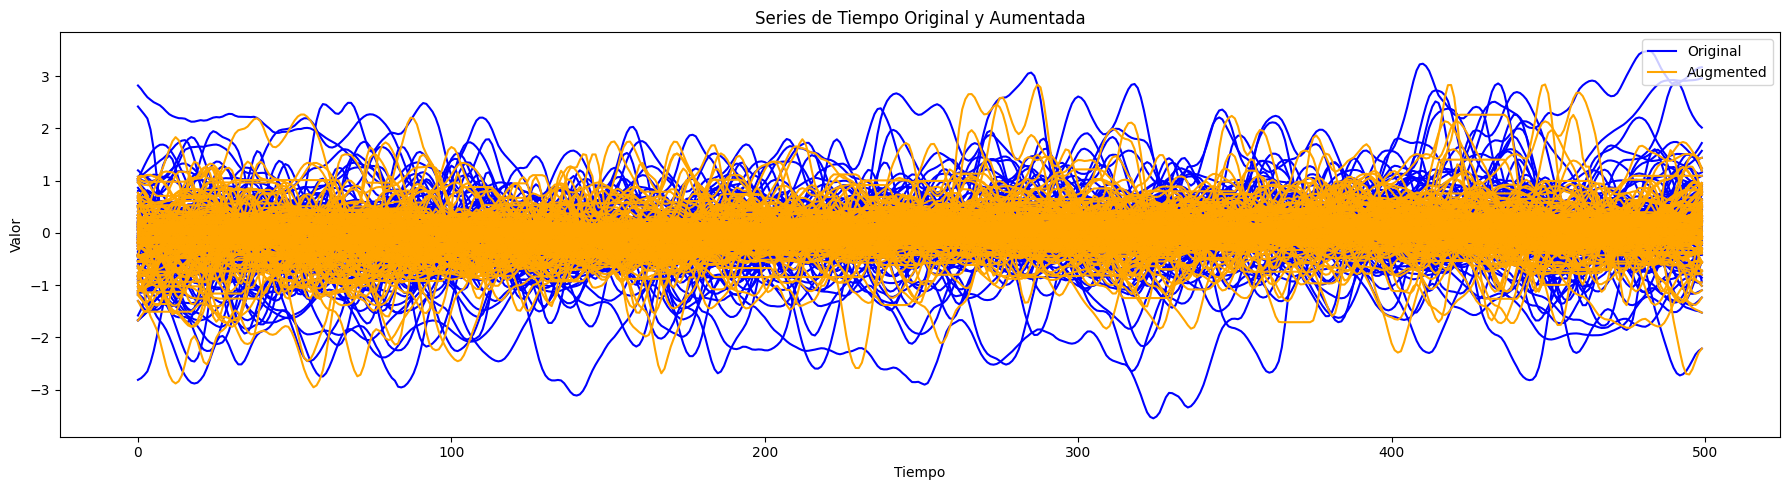

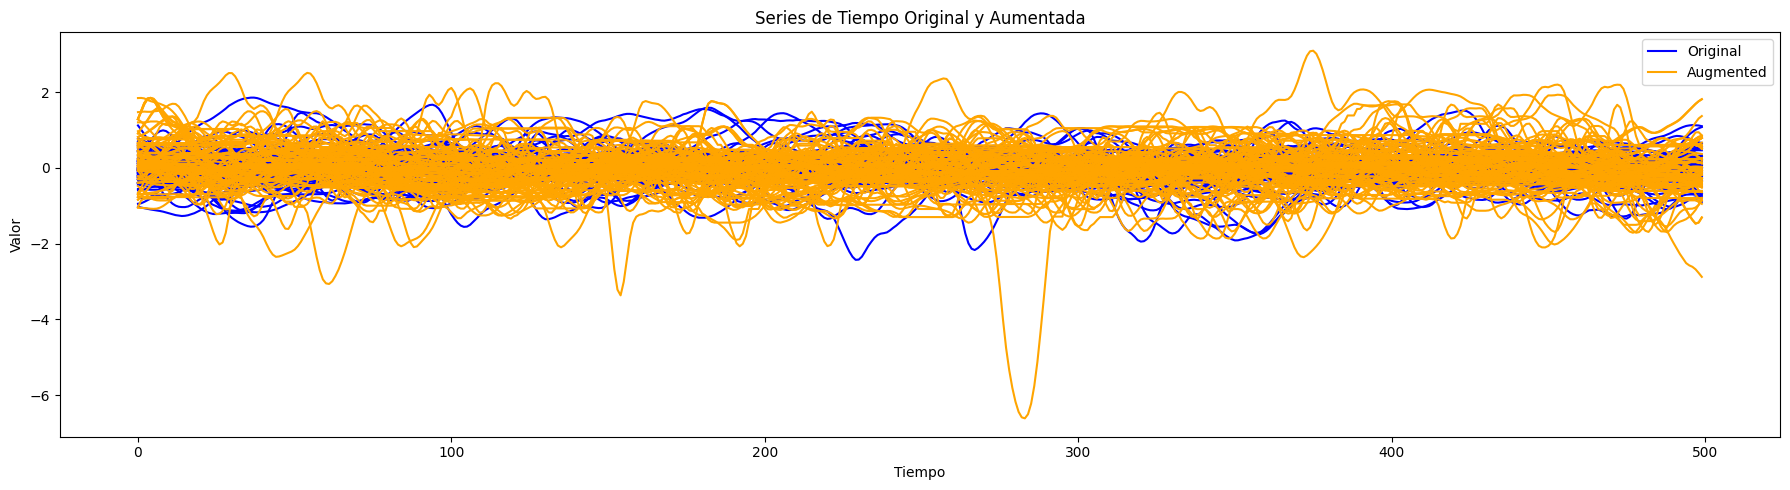

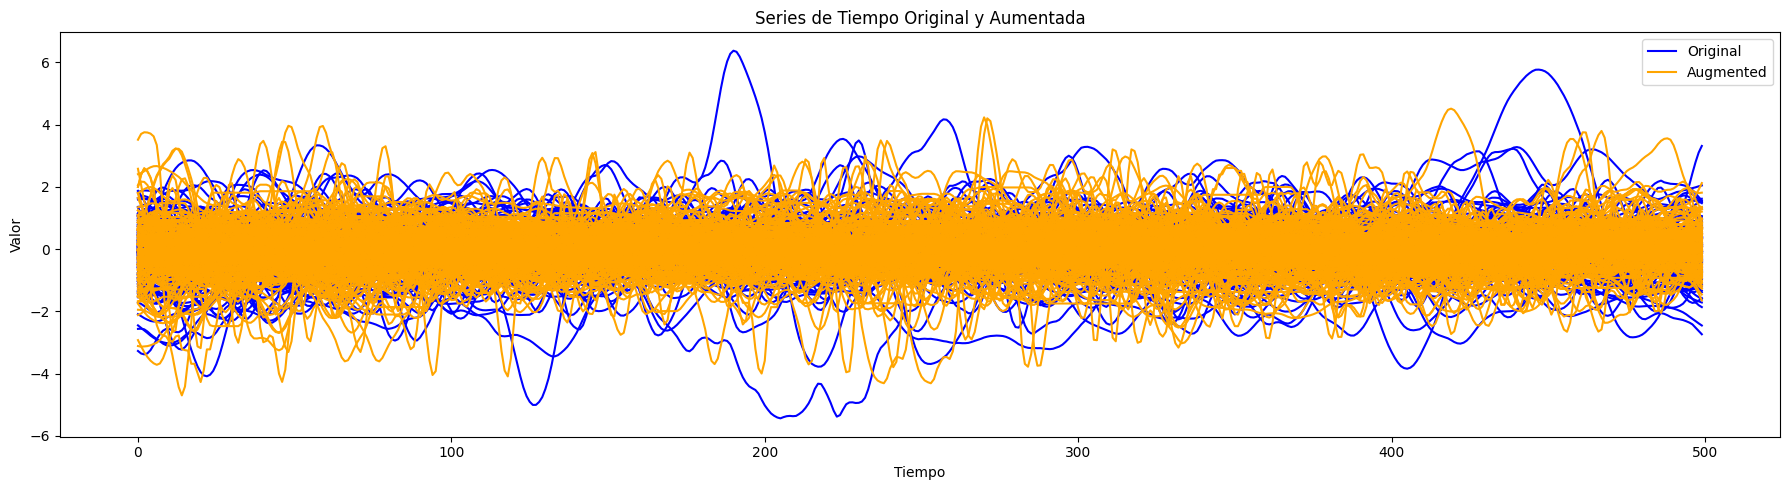

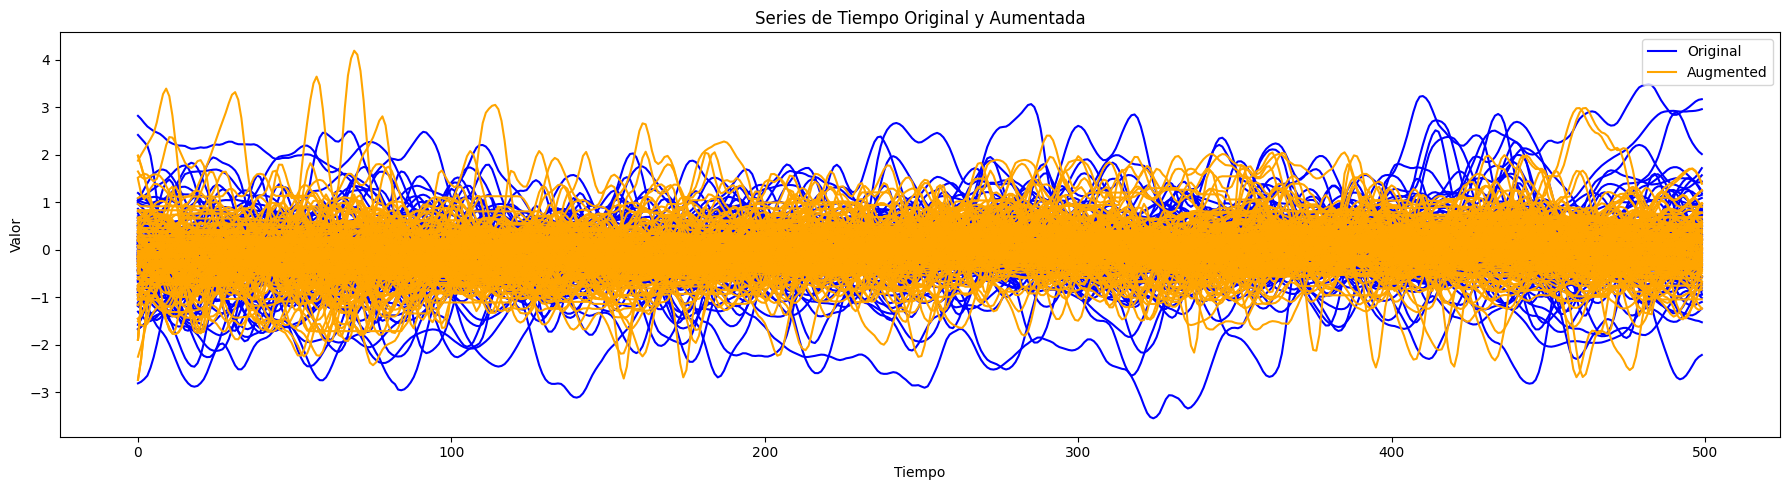

In [28]:

from src.visualization.visualize import plot_series

plot_series(healthy_cop_x, rgw_healthy_x)
plot_series(neuropathic_cop_x, rgw_neuropathic_x)
plot_series(diabetic_cop_x, rgw_diabetic_x)
plot_series(healthy_cop_x, rgw_healthy_y)
plot_series(neuropathic_cop_x, rgw_neuropathic_y)
plot_series(diabetic_cop_x, rgw_diabetic_y)

In [33]:
timeSeries = pd.read_json('../data/processed/rgw_data.json', orient='records', lines=True)


In [34]:
healthy_data = timeSeries[timeSeries['class'] == 'Healthy'].reset_index(drop=True)
neuropathic_data = timeSeries[timeSeries['class'] == 'Neuropathic'].reset_index(drop=True)
diabetic_data = timeSeries[timeSeries['class'] == 'Diabetic'].reset_index(drop=True)

healthy_cop_x = healthy_data['cop_x']
neuropathic_cop_x = neuropathic_data['cop_x']
diabetic_cop_x = diabetic_data['cop_x']

healthy_cop_y = healthy_data['cop_y']
neuropathic_cop_y = neuropathic_data['cop_y']
diabetic_cop_y = diabetic_data['cop_y']


In [35]:
import random
import src.utils.dtw as dtw
import src.models.augmentations as augmentations
import src.visualization.visualize as visualize
import src.utils.data_extraction as extractions

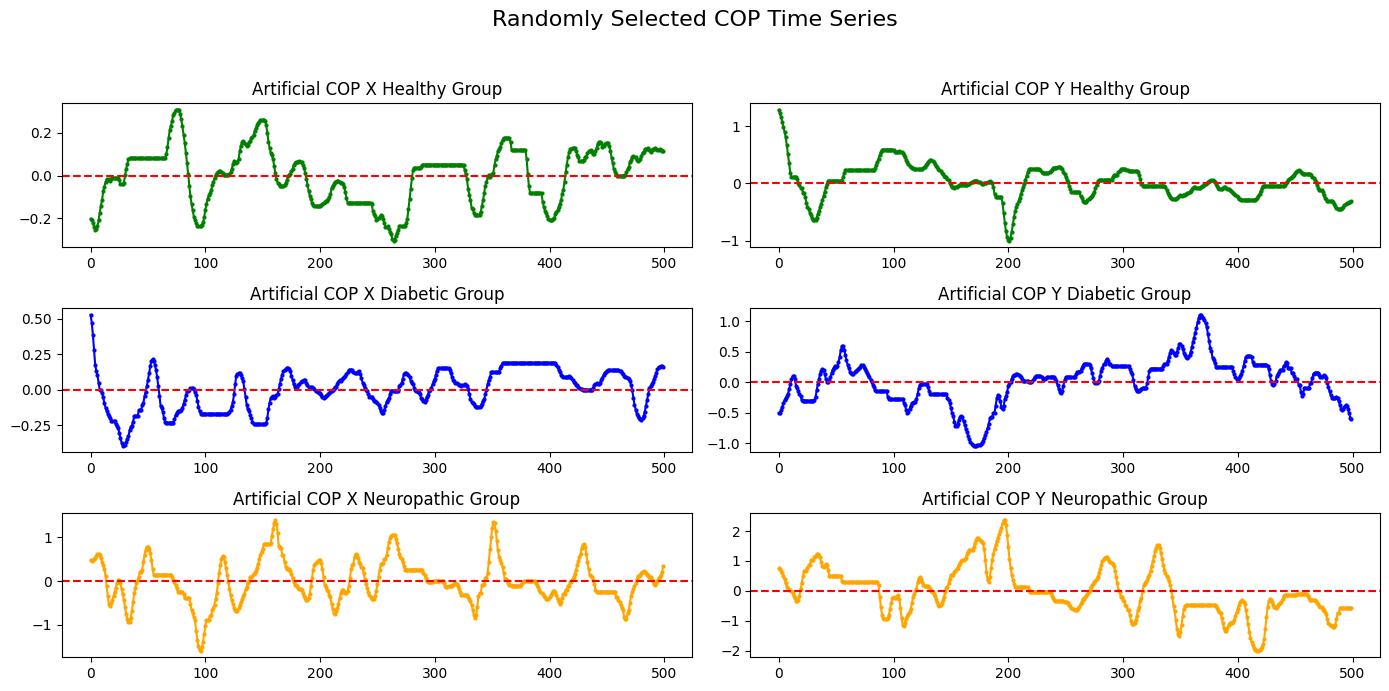

In [36]:
visualize.plot_cop_time_series(healthy_cop_x[400], healthy_cop_y[400],
                     diabetic_cop_x[400], diabetic_cop_y[400],
                     neuropathic_cop_x[400], neuropathic_cop_y[400], export_filename='cop_random_rgw_series')